## XGBOOST VS GLM VS MLP

In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, load_iris
from sklearn.metrics import accuracy_score, confusion_matrix

import xgboost as xgb

np.random.seed(42)
plt.style.use("seaborn-v0_8-darkgrid")


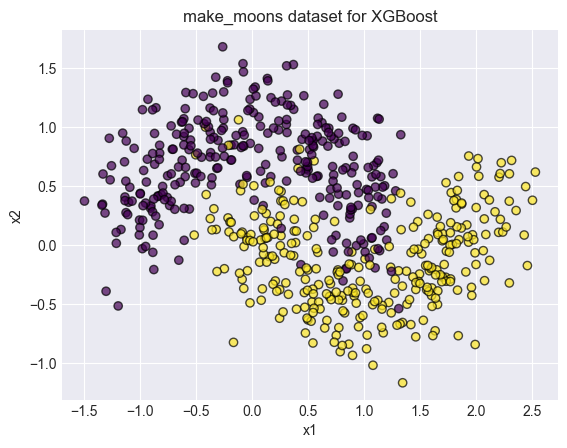

In [4]:
X, y = make_moons(n_samples=600, noise=0.25, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", edgecolor="k", alpha=0.7)
plt.title("make_moons dataset for XGBoost")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


In [5]:
clf = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
acc


0.9

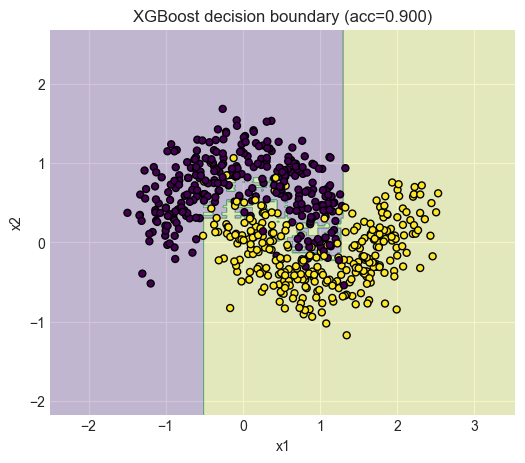

In [6]:
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 400),
        np.linspace(y_min, y_max, 400),
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.25, cmap="viridis")
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", edgecolor="k", s=25)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

plot_decision_boundary(clf, X, y, f"XGBoost decision boundary (acc={acc:.3f})")



In [7]:
iris = load_iris()
X_iris, y_iris = iris.data, iris.target
feature_names = iris.feature_names
class_names = iris.target_names

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_iris, y_iris, test_size=0.3, random_state=42, stratify=y_iris
)

xgb_iris = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1,
)

xgb_iris.fit(X_train_i, y_train_i)

y_pred_i = xgb_iris.predict(X_test_i)
acc_i = accuracy_score(y_test_i, y_pred_i)
acc_i


0.9111111111111111

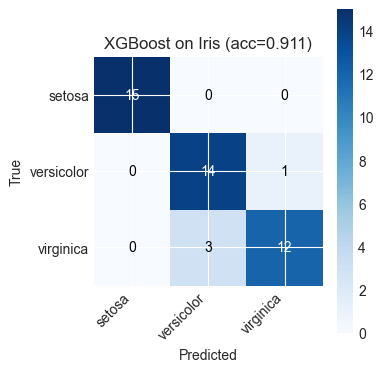

In [8]:
cm = confusion_matrix(y_test_i, y_pred_i)

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm, cmap="Blues")

ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black")

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title(f"XGBoost on Iris (acc={acc_i:.3f})")
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()



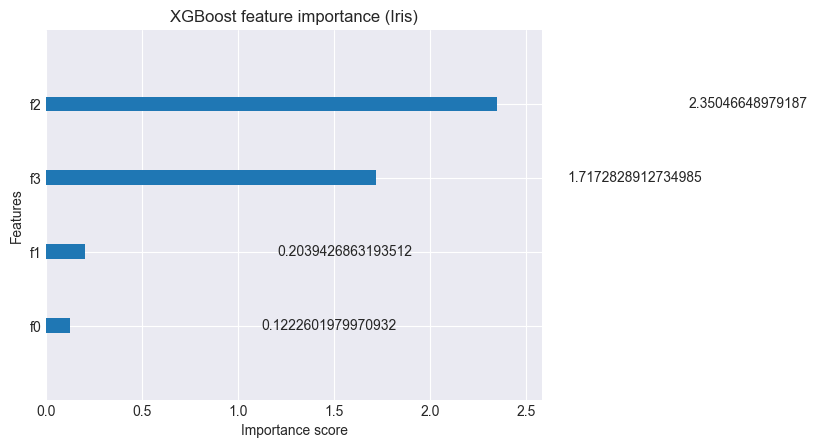

In [9]:
xgb.plot_importance(xgb_iris, importance_type="gain")
plt.title("XGBoost feature importance (Iris)")
plt.show()



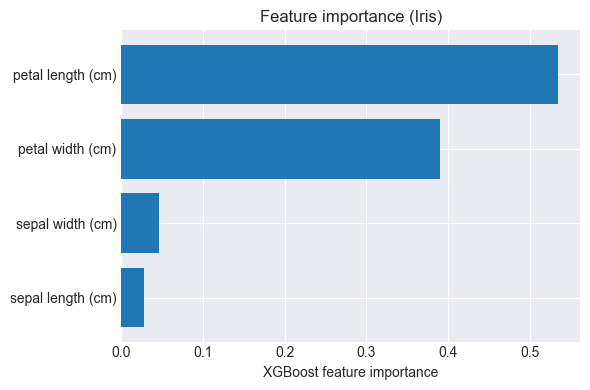

In [10]:
importances = xgb_iris.feature_importances_
idx = np.argsort(importances)

plt.figure(figsize=(6, 4))
plt.barh(np.array(feature_names)[idx], importances[idx])
plt.xlabel("XGBoost feature importance")
plt.title("Feature importance (Iris)")
plt.tight_layout()
plt.show()


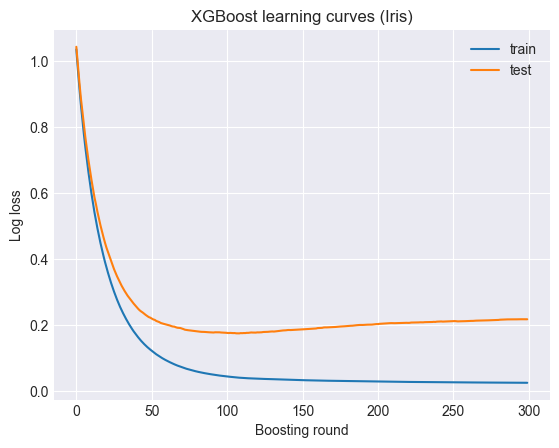

In [14]:
eval_results = {}
xgb_lc = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="mlogloss",      # <‑‑ move here
    random_state=42,
    n_jobs=-1,
)

xgb_lc.fit(
    X_train_i,
    y_train_i,
    eval_set=[(X_train_i, y_train_i), (X_test_i, y_test_i)],
    verbose=False,
)

results = xgb_lc.evals_result_
plt.plot(results["validation_0"]["mlogloss"], label="train")
plt.plot(results["validation_1"]["mlogloss"], label="test")
plt.xlabel("Boosting round")
plt.ylabel("Log loss")
plt.title("XGBoost learning curves (Iris)")
plt.legend()
plt.show()


In [15]:
from sklearn.neural_network import MLPClassifier

mlp_moons = MLPClassifier(
    hidden_layer_sizes=(32, 32),
    activation="relu",
    solver="adam",
    alpha=1e-3,
    learning_rate_init=1e-3,
    max_iter=500,
    random_state=42,
)

mlp_moons.fit(X_train, y_train)

y_pred_mlp = mlp_moons.predict(X_test)
acc_mlp = accuracy_score(y_test, y_pred_mlp)
acc, acc_mlp  # xgboost acc, mlp acc


(0.9, 0.9333333333333333)

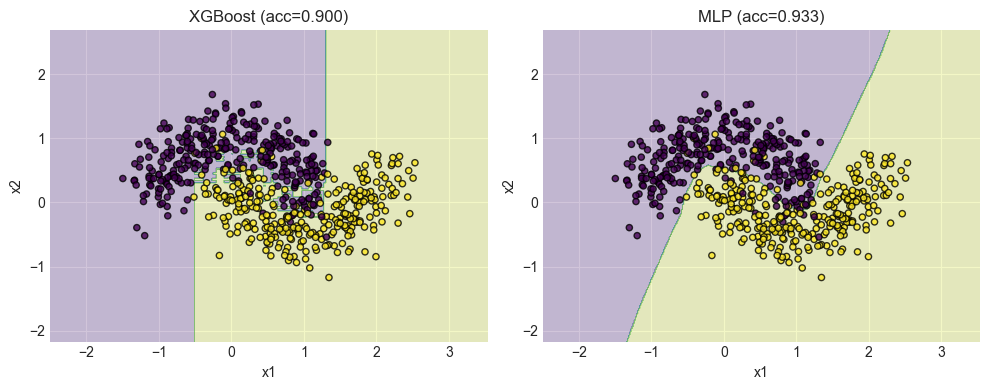

In [16]:
def plot_decision_boundary_compare(models, labels, X, y):
    cols = len(models)
    plt.figure(figsize=(5 * cols, 4))
    for i, (model, lab) in enumerate(zip(models, labels), 1):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, 400),
            np.linspace(y_min, y_max, 400),
        )
        grid = np.c_[xx.ravel(), yy.ravel()]
        Z = model.predict(grid).reshape(xx.shape)

        plt.subplot(1, cols, i)
        plt.contourf(xx, yy, Z, alpha=0.25, cmap="viridis")
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis",
                    edgecolor="k", s=20, alpha=0.8)
        plt.title(lab)
        plt.xlabel("x1")
        plt.ylabel("x2")
    plt.tight_layout()
    plt.show()

plot_decision_boundary_compare(
    [clf, mlp_moons],
    [f"XGBoost (acc={acc:.3f})", f"MLP (acc={acc_mlp:.3f})"],
    X, y,
)


In [17]:
mlp_iris = MLPClassifier(
    hidden_layer_sizes=(32, 32),
    activation="relu",
    solver="adam",
    alpha=1e-3,
    learning_rate_init=1e-3,
    max_iter=1000,
    random_state=42,
)

mlp_iris.fit(X_train_i, y_train_i)
y_pred_i_mlp = mlp_iris.predict(X_test_i)
acc_i_mlp = accuracy_score(y_test_i, y_pred_i_mlp)
acc_i, acc_i_mlp  # xgboost vs mlp


(0.9111111111111111, 0.9777777777777777)

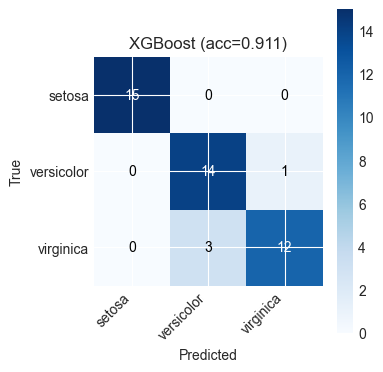

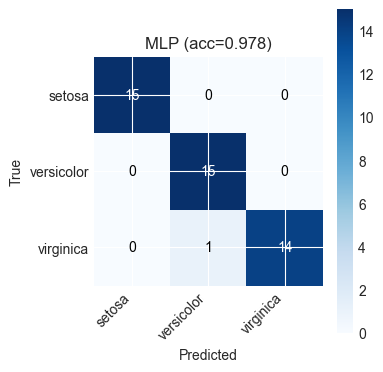

In [18]:
cm_xgb = confusion_matrix(y_test_i, y_pred_i)
cm_mlp = confusion_matrix(y_test_i, y_pred_i_mlp)

def plot_confusion(cm, class_names, title):
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")

    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black")

    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

plot_confusion(cm_xgb, class_names,
               f"XGBoost (acc={acc_i:.3f})")
plot_confusion(cm_mlp, class_names,
               f"MLP (acc={acc_i_mlp:.3f})")


In [20]:
import os
project_root = os.path.abspath("..")      
if project_root not in sys.path:
    sys.path.append(project_root)


In [21]:
from generative_models.NaiveBayes import GaussianNaiveBayes, MultinomialNaiveBayes
from discriminative_models.GLM import BernoulliLogitGLM, SoftmaxGLM
from generative_models.GDA import GDA, GDA_Multiclass

In [22]:

# GLM (logistic regression) on moons
glm_moons = BernoulliLogitGLM(lr=0.1, n_iters=2000)
glm_moons.fit(X_train, y_train)
y_pred_glm = glm_moons.predict(X_test)
acc_glm = accuracy_score(y_test, y_pred_glm)

acc, acc_mlp, acc_glm  # xgboost, mlp, glm


(0.9, 0.9333333333333333, 0.8444444444444444)

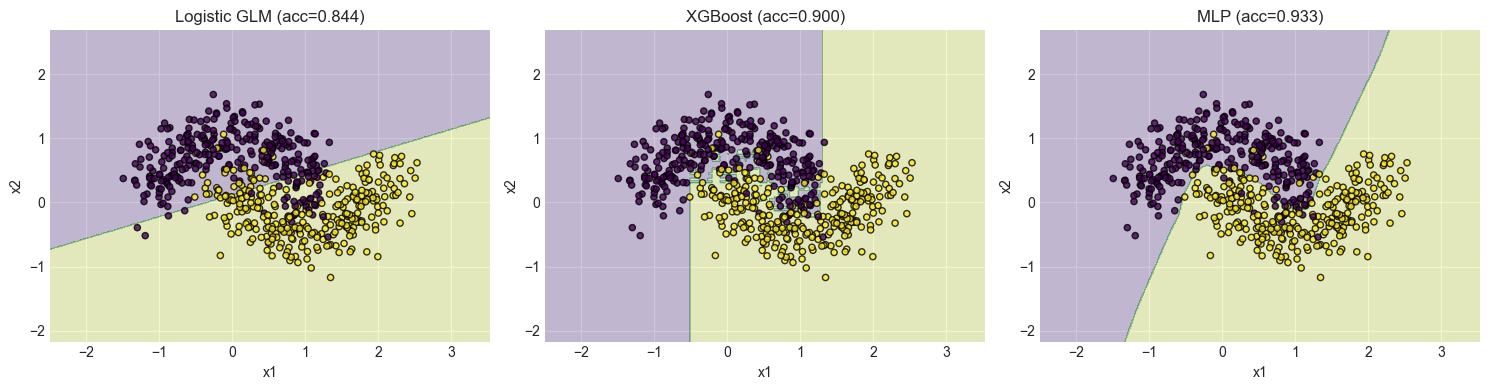

In [23]:
plot_decision_boundary_compare(
    [glm_moons, clf, mlp_moons],
    [
        f"Logistic GLM (acc={acc_glm:.3f})",
        f"XGBoost (acc={acc:.3f})",
        f"MLP (acc={acc_mlp:.3f})",
    ],
    X, y,
)


In [25]:

softmax_glm_iris = SoftmaxGLM(lr=0.1, n_iters=1000, method="batch")
softmax_glm_iris.fit(X_train_i, y_train_i)
y_pred_soft = softmax_glm_iris.predict(X_test_i)
acc_soft = accuracy_score(y_test_i, y_pred_soft)

acc_i, acc_i_mlp, acc_soft  # xgboost, mlp, glm-softmax


(0.9111111111111111, 0.9777777777777777, 0.9777777777777777)

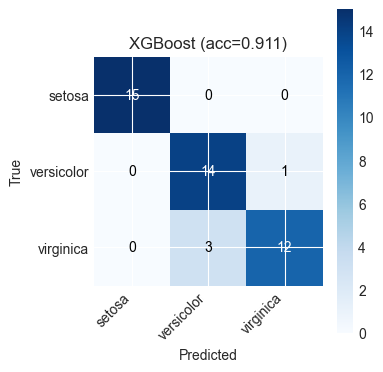

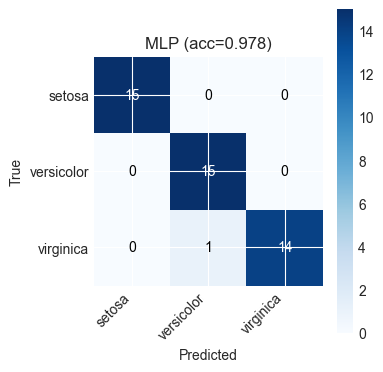

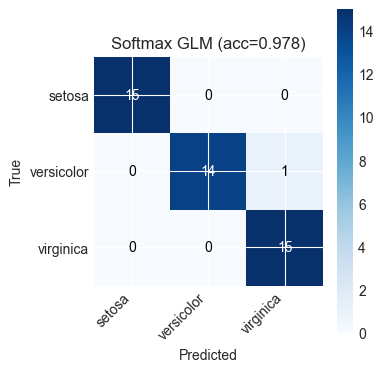

In [26]:
cm_soft = confusion_matrix(y_test_i, y_pred_soft)

plot_confusion(cm_xgb, class_names,
               f"XGBoost (acc={acc_i:.3f})")
plot_confusion(cm_mlp, class_names,
               f"MLP (acc={acc_i_mlp:.3f})")
plot_confusion(cm_soft, class_names,
               f"Softmax GLM (acc={acc_soft:.3f})")


In [27]:
from sklearn.ensemble import RandomForestClassifier

# RandomForest on moons
rf_moons = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1,
)

rf_moons.fit(X_train, y_train)
y_pred_rf = rf_moons.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

acc_glm, acc, acc_mlp, acc_rf  # logistic GLM, XGBoost, MLP, RF


(0.8444444444444444, 0.9, 0.9333333333333333, 0.9277777777777778)

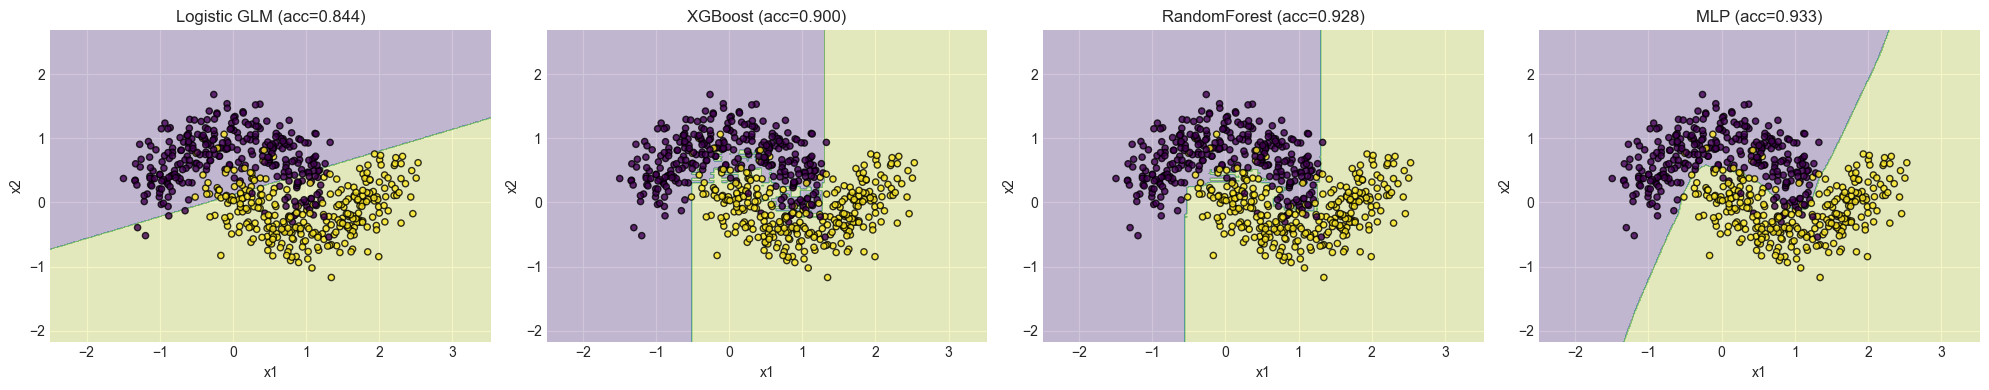

In [28]:
plot_decision_boundary_compare(
    [glm_moons, clf, rf_moons, mlp_moons],
    [
        f"Logistic GLM (acc={acc_glm:.3f})",
        f"XGBoost (acc={acc:.3f})",
        f"RandomForest (acc={acc_rf:.3f})",
        f"MLP (acc={acc_mlp:.3f})",
    ],
    X, y,
)


In [29]:
rf_iris = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1,
)

rf_iris.fit(X_train_i, y_train_i)
y_pred_rf_i = rf_iris.predict(X_test_i)
acc_rf_i = accuracy_score(y_test_i, y_pred_rf_i)

acc_soft, acc_i, acc_i_mlp, acc_rf_i  # softmax GLM, XGBoost, MLP, RF


(0.9777777777777777,
 0.9111111111111111,
 0.9777777777777777,
 0.9111111111111111)

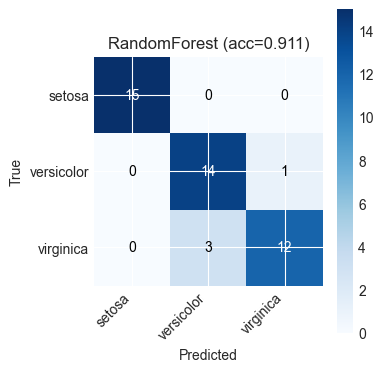

In [30]:
cm_rf = confusion_matrix(y_test_i, y_pred_rf_i)
plot_confusion(cm_rf, class_names,
               f"RandomForest (acc={acc_rf_i:.3f})")
               


In [31]:
print("Iris accuracies:")
print(f"  Softmax GLM : {acc_soft:.3f}")
print(f"  XGBoost     : {acc_i:.3f}")
print(f"  MLP         : {acc_i_mlp:.3f}")
print(f"  RandomForest: {acc_rf_i:.3f}")


Iris accuracies:
  Softmax GLM : 0.978
  XGBoost     : 0.911
  MLP         : 0.978
  RandomForest: 0.911
